In [1]:
!pip install tensorflow
import os

# Defining each of these directories

In [2]:
train_dir = os.path.join('../input/railway-track-fault-detection/dataset/Train')
validation_dir = os.path.join('../input/railway-track-fault-detection/dataset/Validation')

# Directory with our training defective/nondefective pictures
train_defective_dir = os.path.join('../input/railway-track-fault-detection/dataset/Train/Defective')
train_nondefective_dir = os.path.join('../input/railway-track-fault-detection/dataset/Train/Non defective')

# Directory with our validation defective/nondefective pictures
validation_defective_dir = os.path.join('../input/railway-track-fault-detection/dataset/Validation/Defective')
validation_nondefective_dir = os.path.join('../input/railway-track-fault-detection/dataset/Validation/Non defective')

**Now, let's see what the filenames look like in the training directories:**

In [3]:
train_defective_fnames = os.listdir(train_defective_dir )
train_nondefective_fnames = os.listdir( train_nondefective_dir)

print(train_defective_fnames[:20])
print(train_nondefective_fnames[:20])

['IMG_20201114_102058.jpg', 'IMG_20201114_103138.jpg', 'IMG_20201114_101930.jpg', 'IMG_20201114_101823.jpg', 'IMG_20201114_102936.jpg', 'IMG_20201114_100946.jpg', 'IMG_20201114_102816.jpg', 'IMG_20201114_102338.jpg', 'IMG_20201114_101946.jpg', 'IMG_20201114_102824.jpg', 'IMG_20201114_102340.jpg', 'IMG_20201114_101628.jpg', 'IMG_20201114_102415.jpg', 'IMG_20201114_101143.jpg', 'IMG_20201114_103150.jpg', 'IMG_20201114_102732.jpg', 'IMG_20201114_103059.jpg', 'IMG_20201114_101130.jpg', 'IMG_20201114_102230.jpg', 'IMG_20201114_103058.jpg']
['IMG_20201114_100853.jpg', 'IMG_20201114_101031.jpg', 'IMG_20201114_102443.jpg', 'IMG_20201114_102545.jpg', 'IMG_20201114_100245.jpg', 'IMG_20201114_101519.jpg', 'IMG_20201114_103326.jpg', 'IMG_20201114_102117.jpg', 'IMG_20201114_102319.jpg', 'IMG_20201114_101807.jpg', 'IMG_20201114_102641.jpg', 'IMG_20201114_103055.jpg', 'IMG_20201114_103008.jpg', 'IMG_20201114_102602.jpg', 'IMG_20201114_100050.jpg', 'IMG_20201114_101556.jpg', 'IMG_20201114_102902.jpg',

In [4]:
print('total training defective images :', len(os.listdir(train_defective_dir)))
print('total training non-defective images :', len(os.listdir(train_nondefective_dir)))


print('total validation defective images :', len(os.listdir( validation_defective_dir ) ))
print('total validation non-defective images :', len(os.listdir( validation_nondefective_dir) ))

total training defective images : 54
total training non-defective images : 136
total validation defective images : 25
total validation non-defective images : 65


**Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:**

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

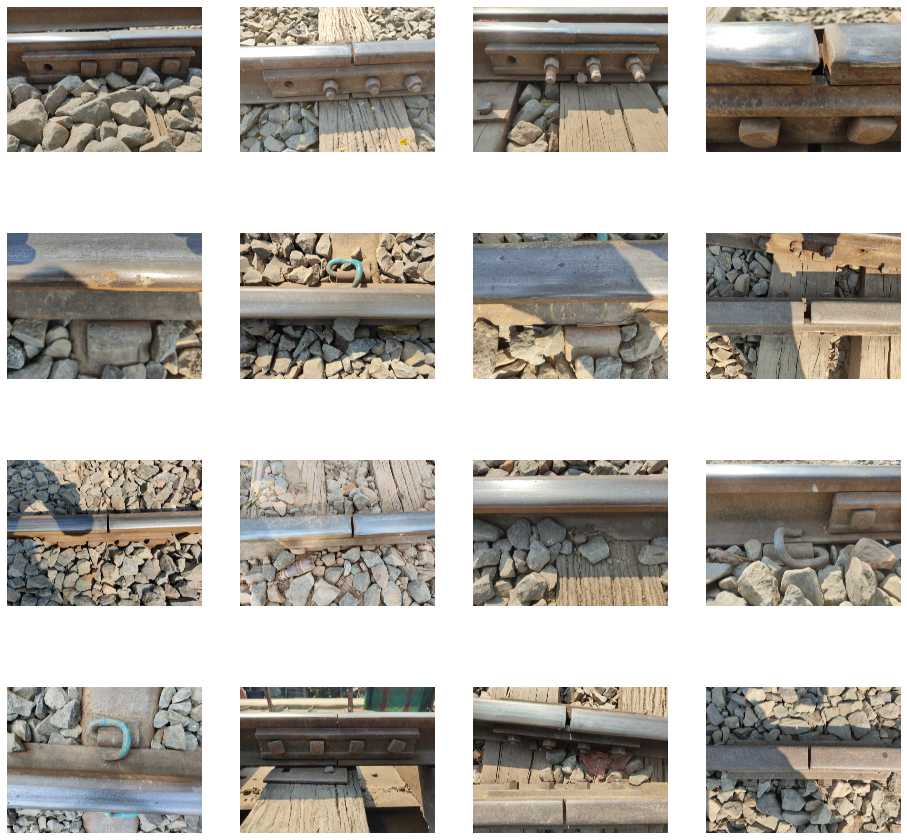

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_defective_pix = [os.path.join(train_defective_dir, fname) 
                for fname in train_defective_fnames[pic_index-8:pic_index]]
next_nondefective_pix = [os.path.join(train_nondefective_dir, fname) 
                for fname in train_nondefective_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_defective_pix+next_nondefective_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:
import tensorflow as tf

**The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.**

# Pre-Trained Model

In [8]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


pre_trained_model = InceptionV3(input_shape = (300,300, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Data Preprocessing

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(300,300))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (300,300))

Found 190 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


**We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.**
**Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).**

In [10]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=10,
                              epochs=30,
                              validation_steps=5,
                              verbose=2)

Epoch 1/30
10/10 - 92s - loss: 0.9659 - accuracy: 0.6579 - val_loss: 0.5621 - val_accuracy: 0.7222
Epoch 2/30
10/10 - 63s - loss: 0.6296 - accuracy: 0.6737 - val_loss: 0.5417 - val_accuracy: 0.7222
Epoch 3/30
10/10 - 66s - loss: 0.5840 - accuracy: 0.7211 - val_loss: 0.5528 - val_accuracy: 0.7222
Epoch 4/30
10/10 - 63s - loss: 0.5700 - accuracy: 0.7158 - val_loss: 0.5095 - val_accuracy: 0.7333
Epoch 5/30
10/10 - 63s - loss: 0.5852 - accuracy: 0.6684 - val_loss: 0.5829 - val_accuracy: 0.7222
Epoch 6/30
10/10 - 64s - loss: 0.5775 - accuracy: 0.7105 - val_loss: 0.5312 - val_accuracy: 0.7222
Epoch 7/30
10/10 - 63s - loss: 0.5100 - accuracy: 0.7684 - val_loss: 0.4922 - val_accuracy: 0.7556
Epoch 8/30
10/10 - 62s - loss: 0.5055 - accuracy: 0.7316 - val_loss: 0.6040 - val_accuracy: 0.7222
Epoch 9/30
10/10 - 64s - loss: 0.5429 - accuracy: 0.7158 - val_loss: 0.5596 - val_accuracy: 0.7444
Epoch 10/30
10/10 - 63s - loss: 0.4495 - accuracy: 0.7789 - val_loss: 0.4722 - val_accuracy: 0.7444
Epoch 11/

Text(0.5, 1.0, 'Training and validation loss')

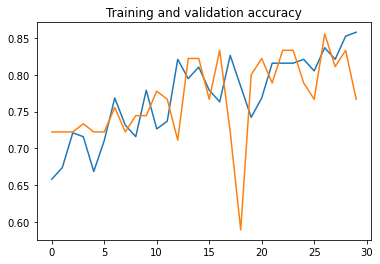

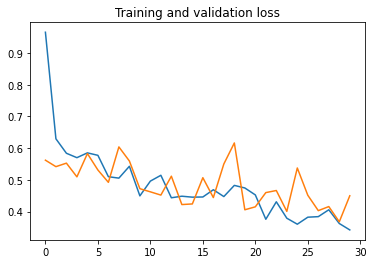

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'  )

**Visualizing Intermediate Representations
To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.
Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.**

[[1.]]
This Railway track has no fault


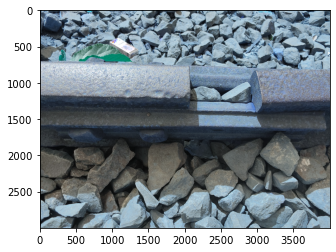

In [14]:
import cv2
import numpy as np
img = cv2.imread('../input/railway-track-fault-detection/dataset/Test/Defective/IMG_20201114_102203.jpg')
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")

TypeError: Image data of dtype object cannot be converted to float

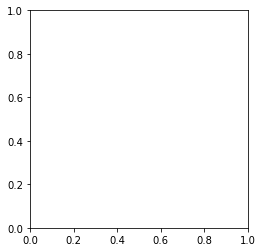

In [15]:
import cv2
import numpy as np
img = cv2.imread('')
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


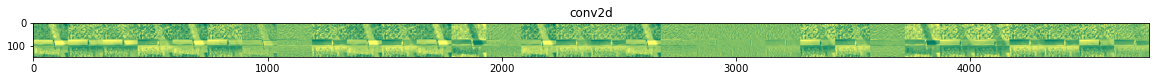

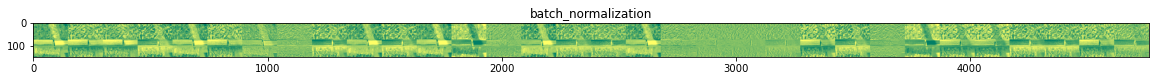

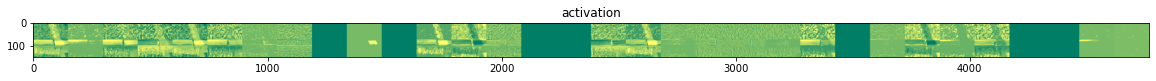

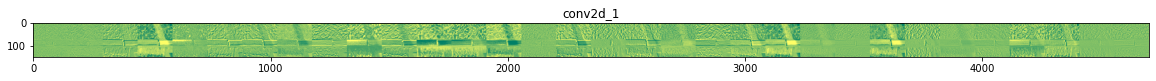

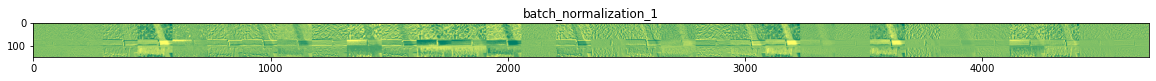

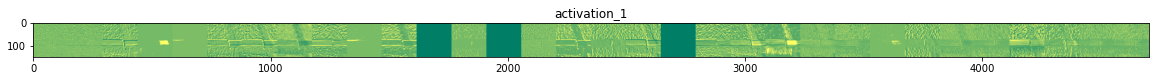

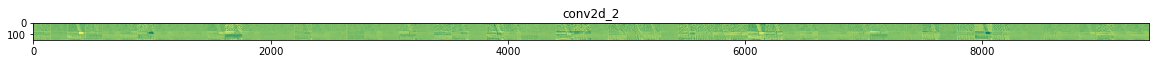

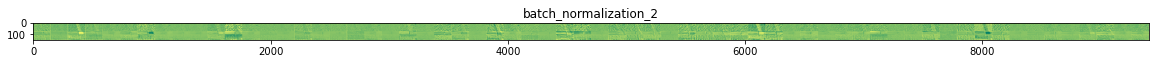

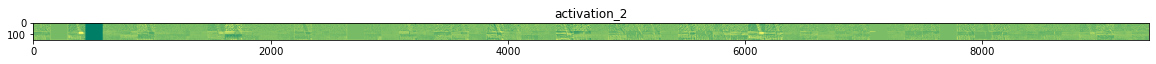

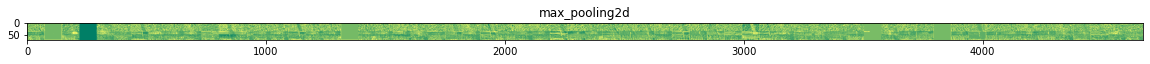

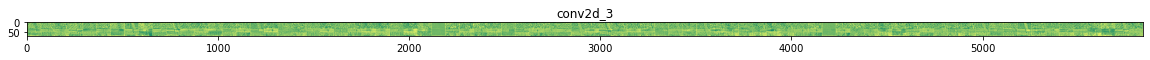

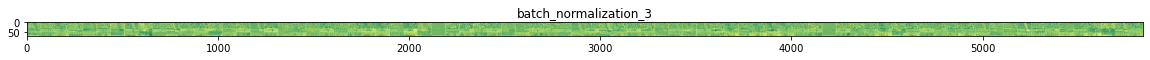

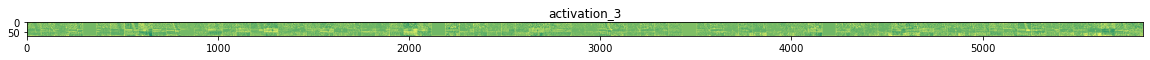

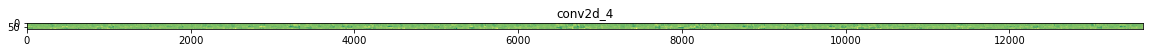

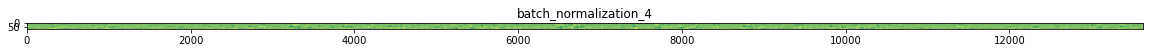

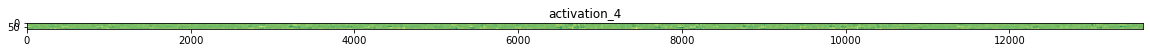

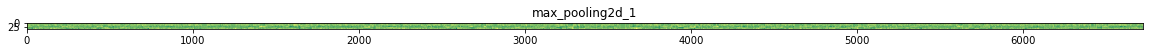

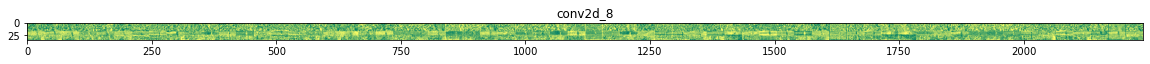

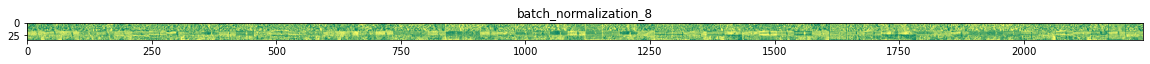

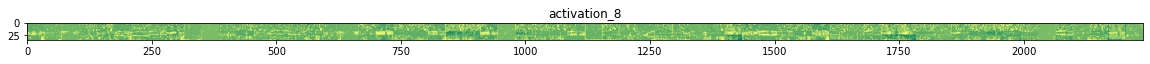

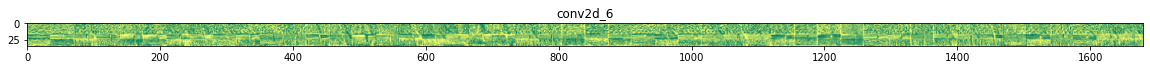

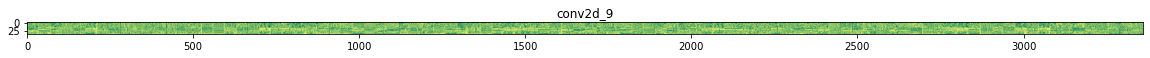

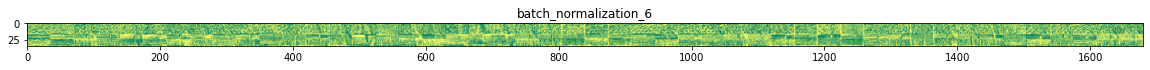

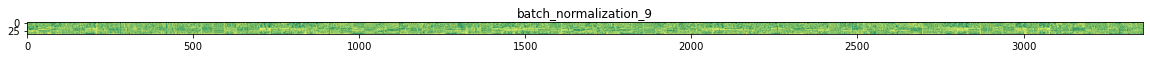

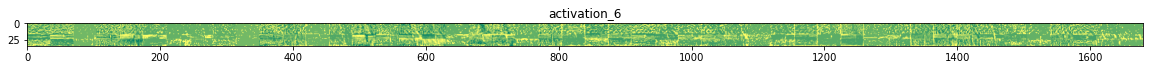

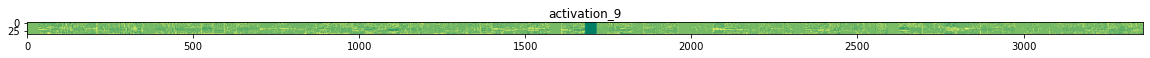

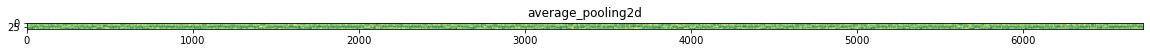

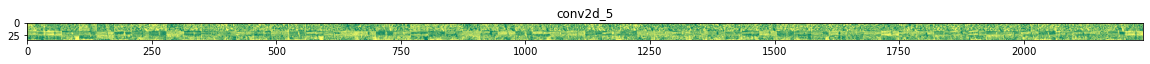

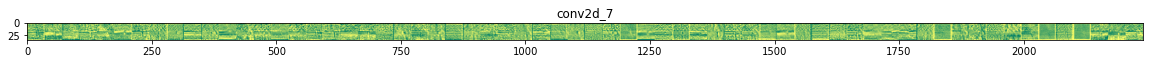

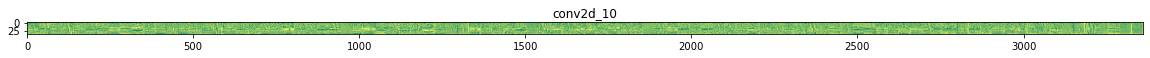

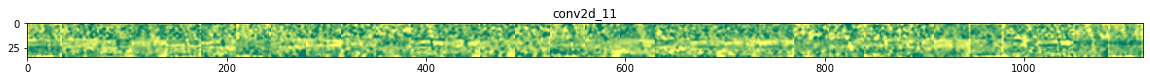

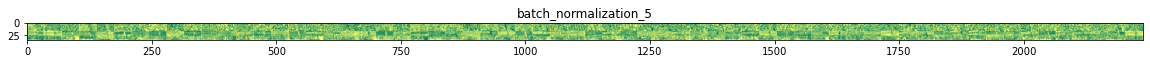

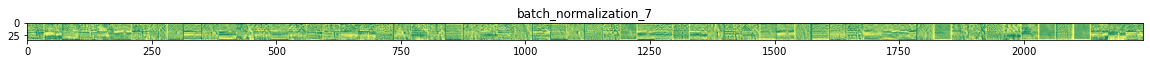

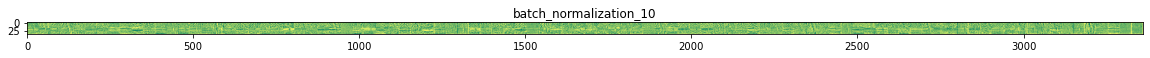

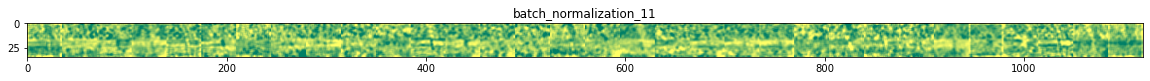

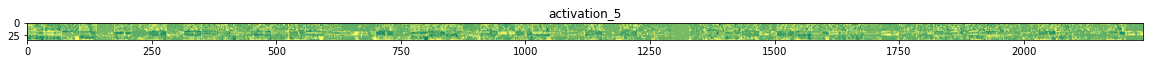

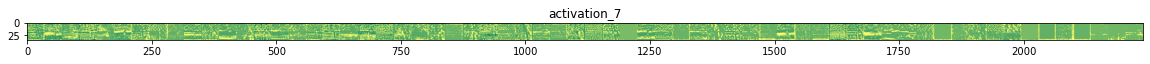

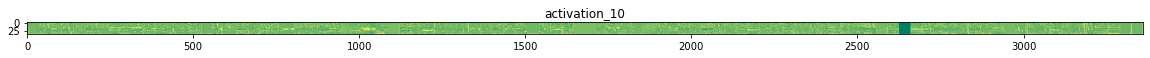

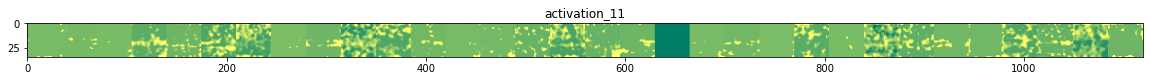

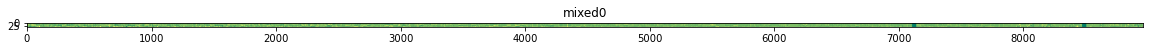

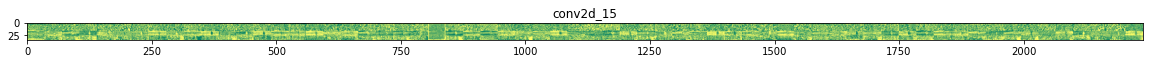

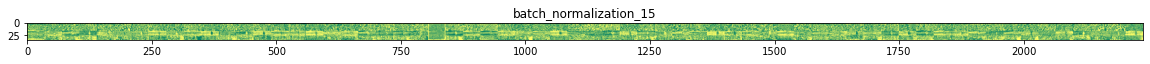

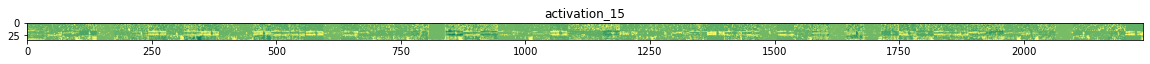

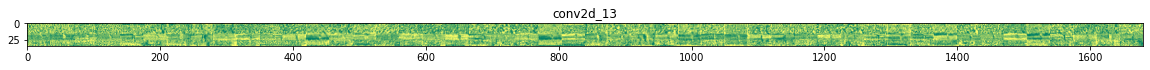

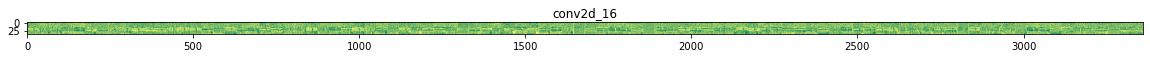

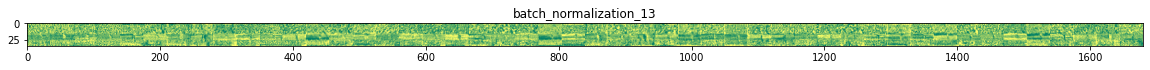

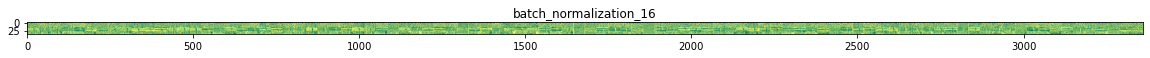

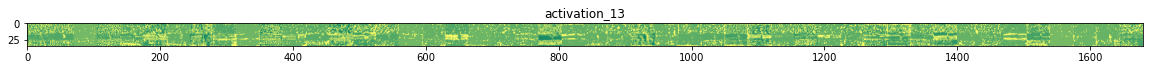

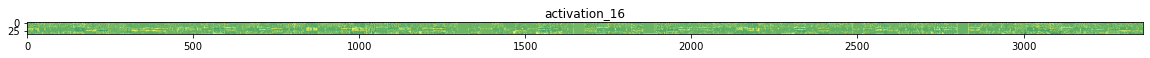

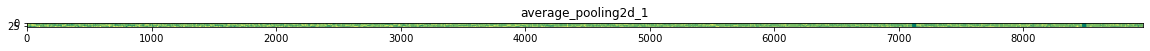

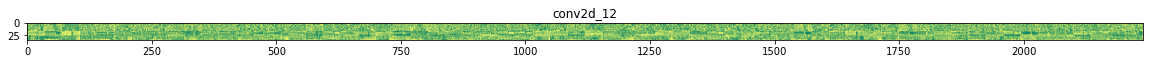

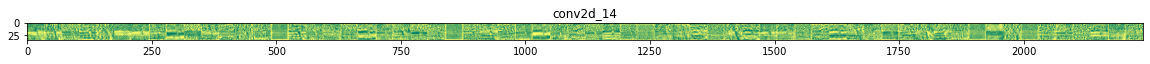

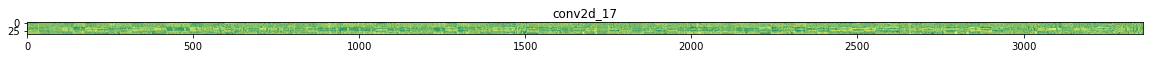

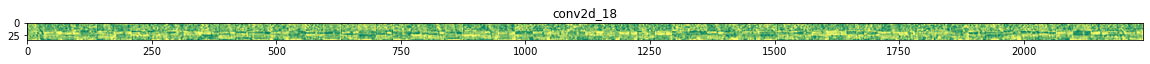

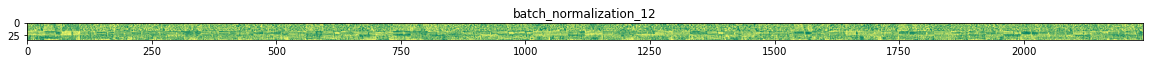

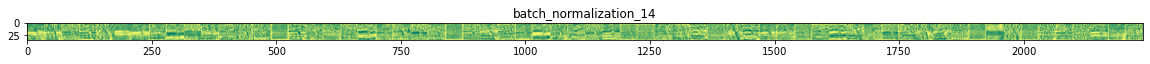

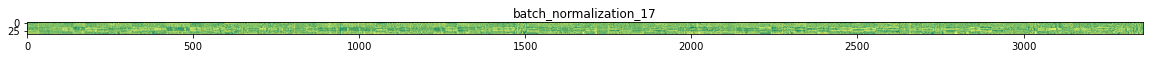

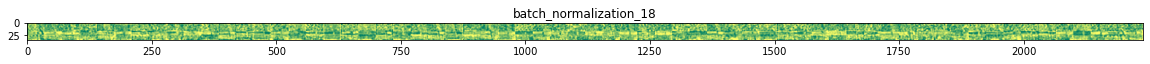

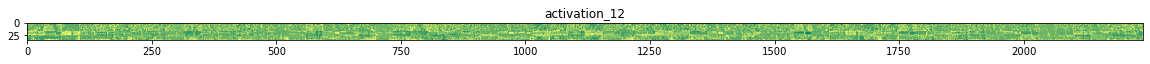

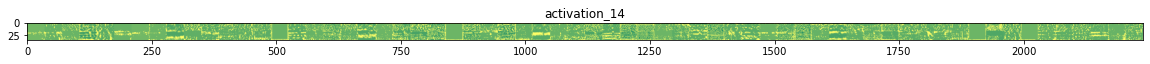

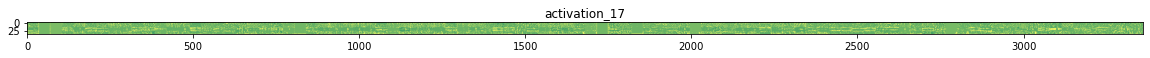

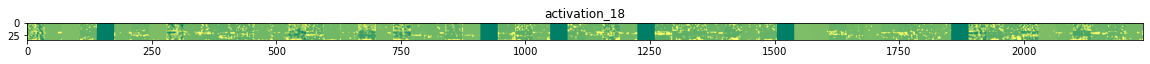

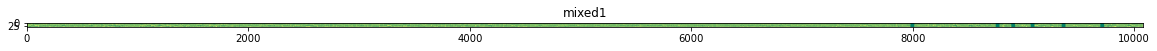

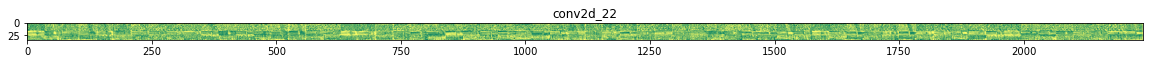

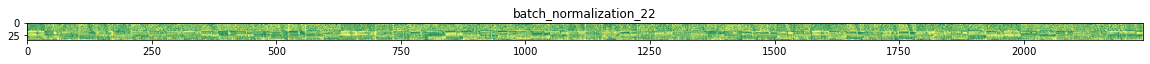

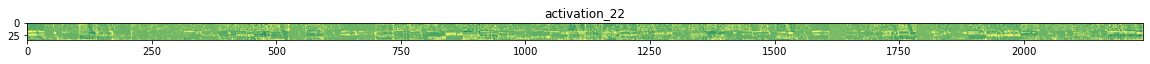

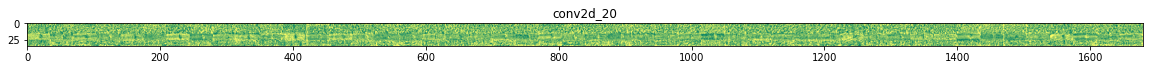

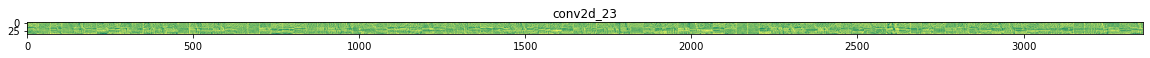

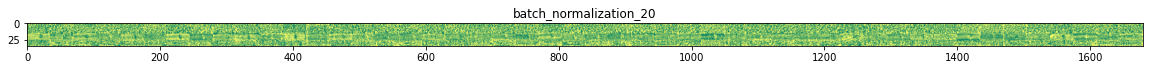

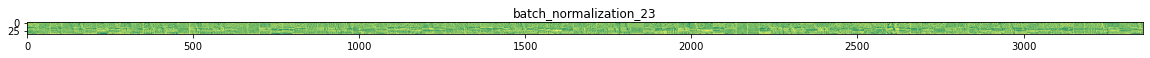

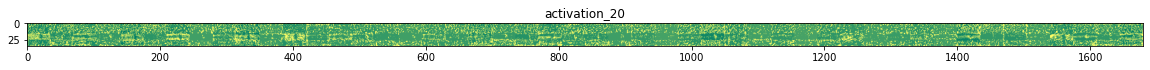

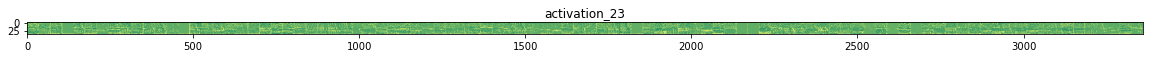

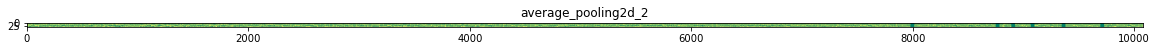

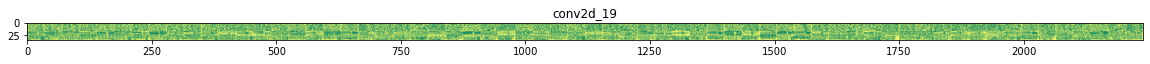

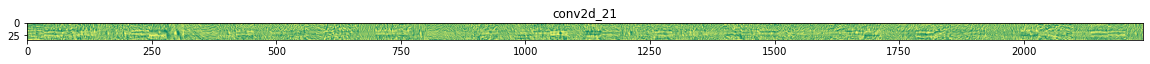

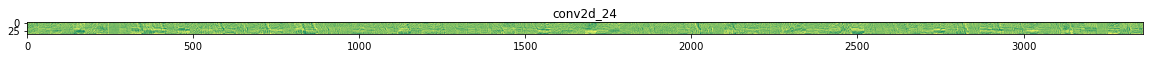

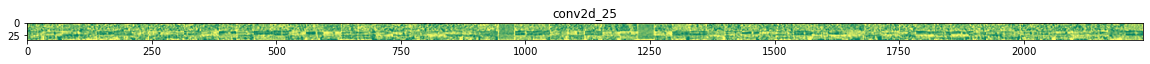

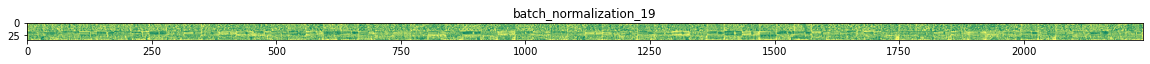

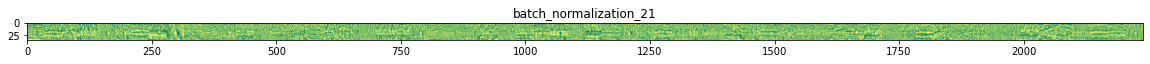

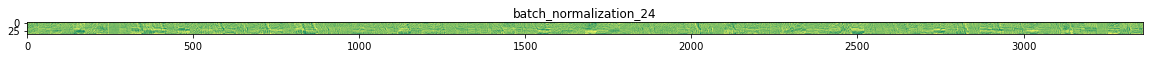

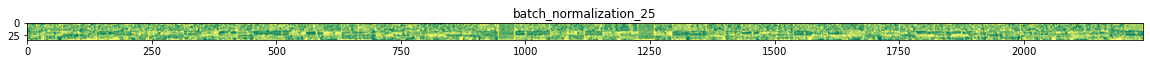

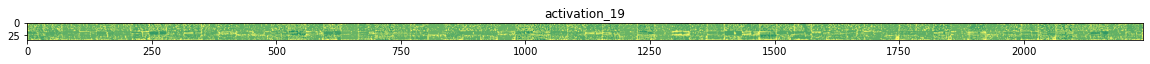

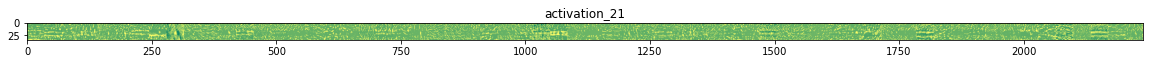

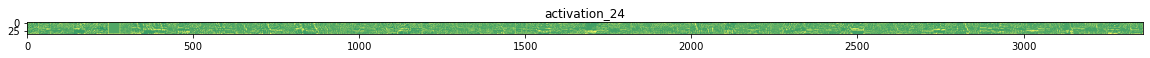

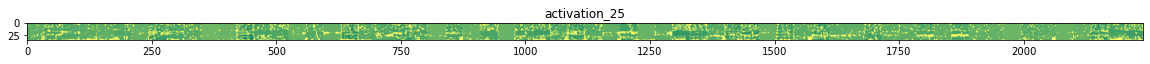

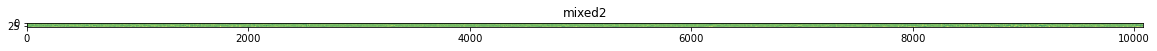

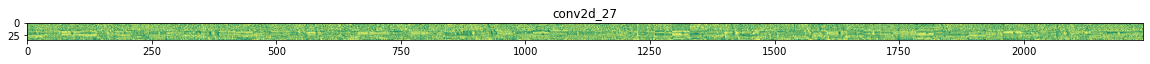

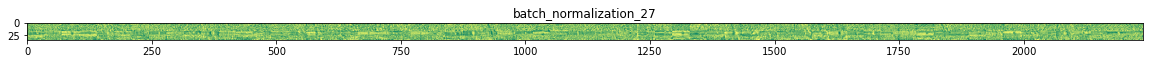

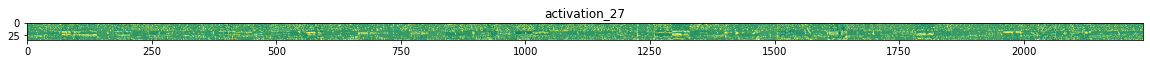

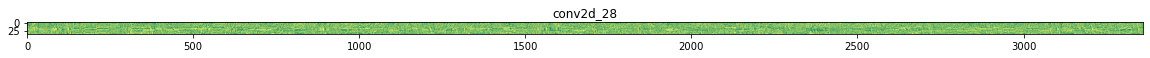

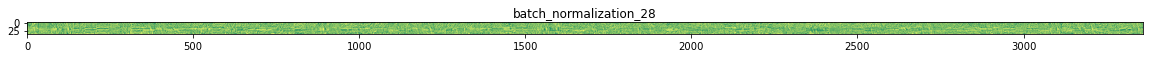

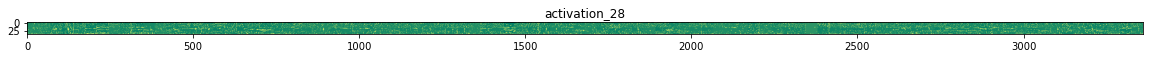

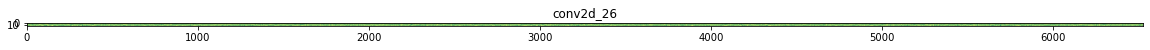

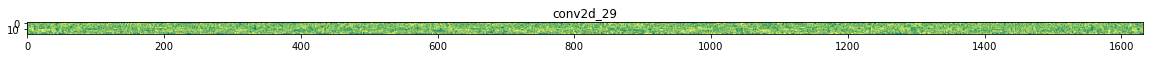

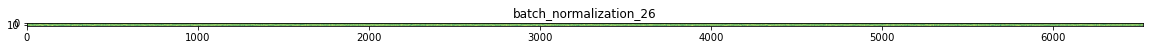

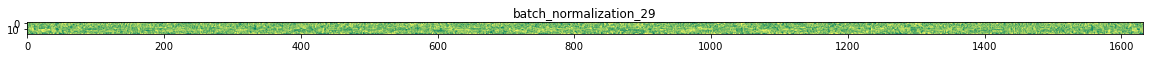

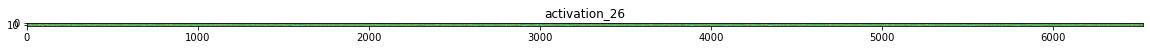

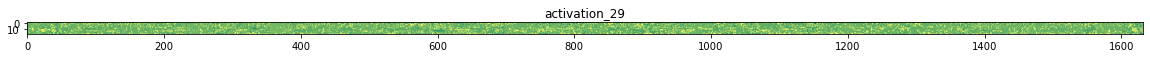

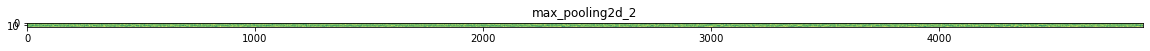

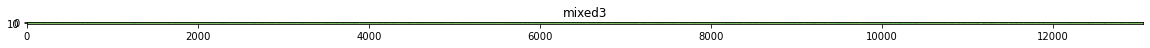

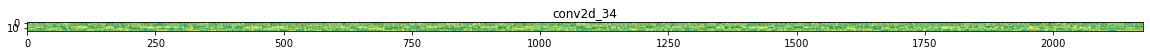

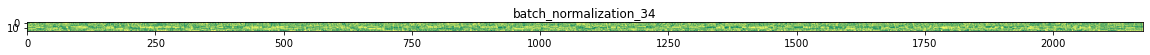

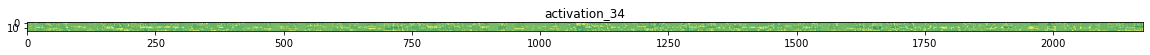

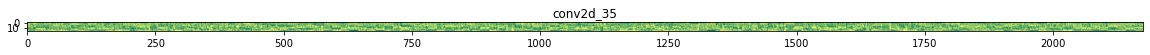

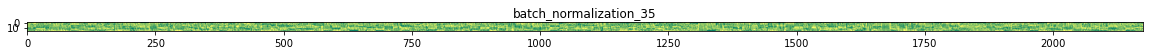

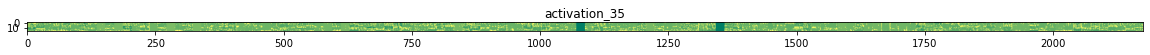

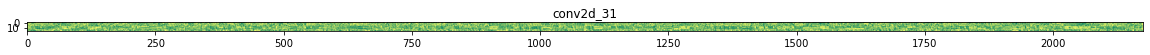

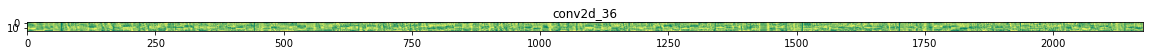

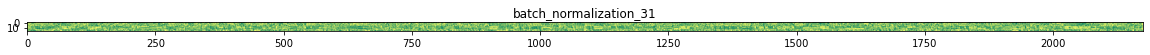

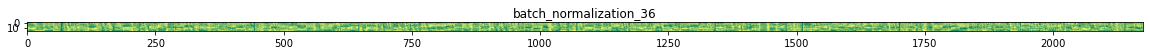

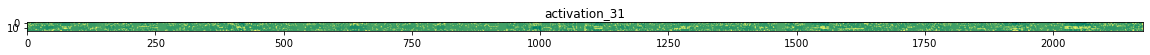

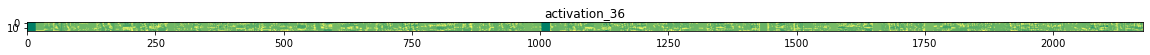

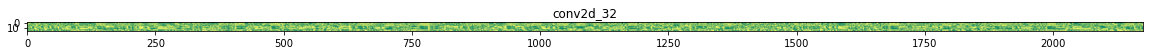

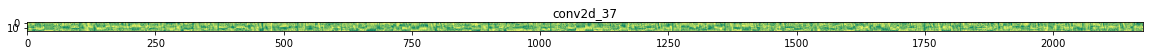

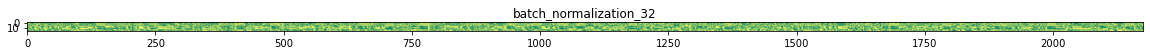

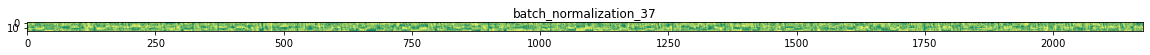

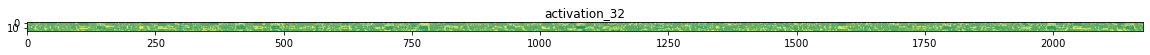

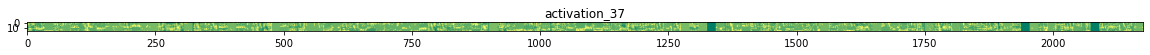

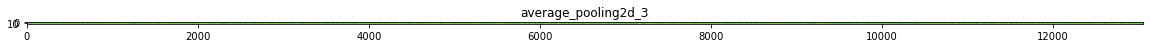

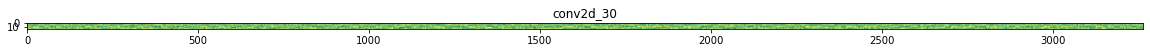

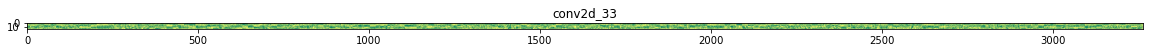

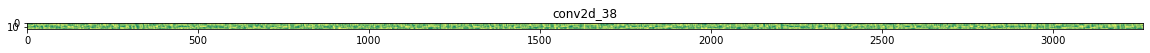

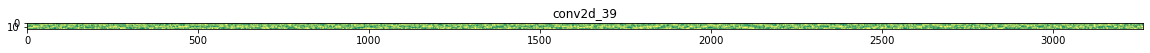

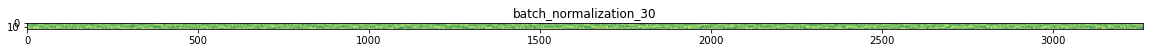

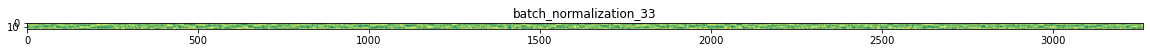

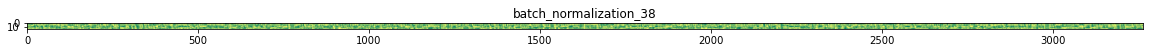

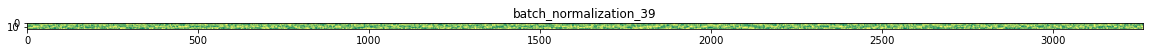

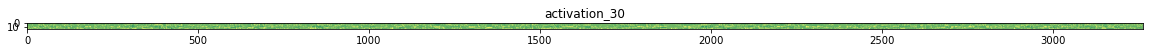

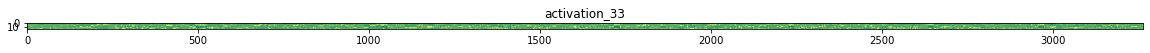

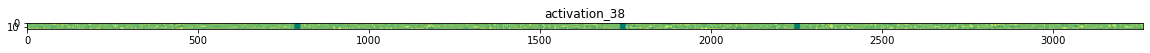

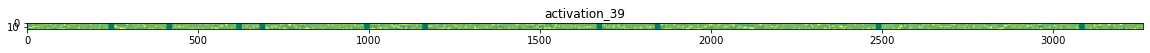

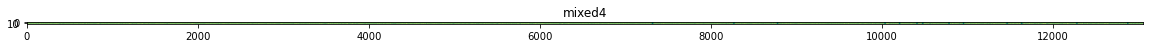

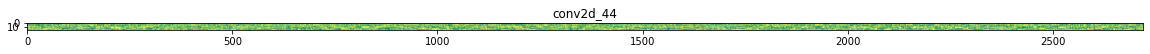

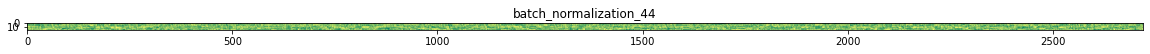

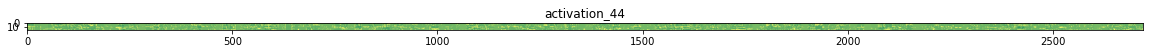

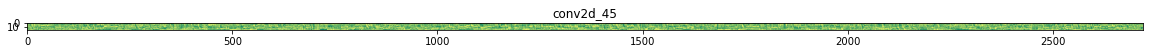

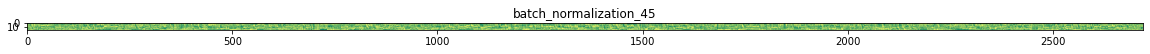

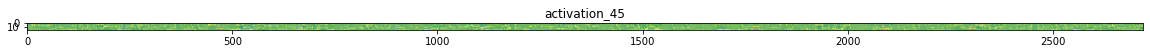

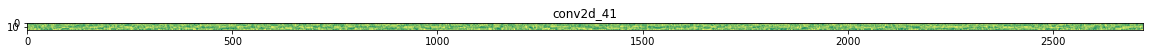

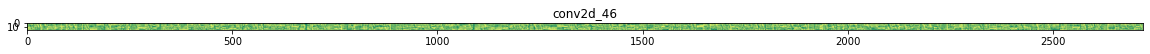

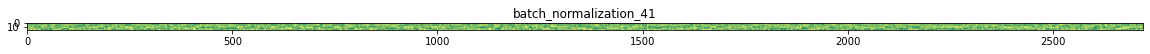

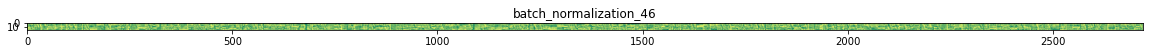

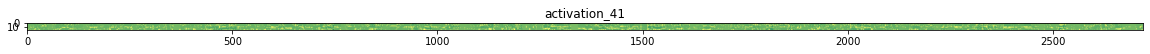

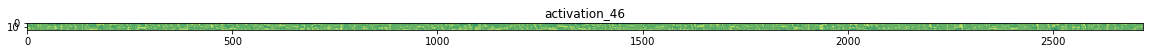

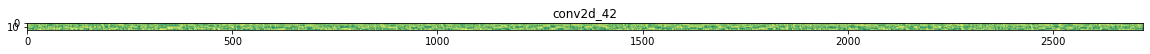

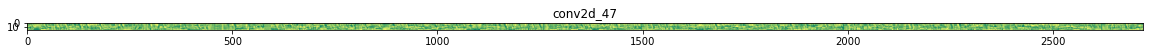

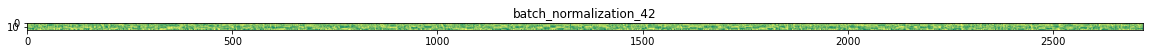

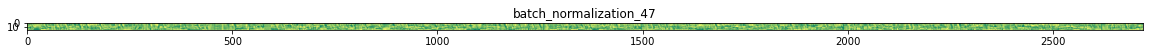

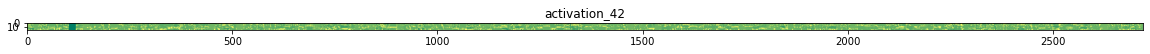

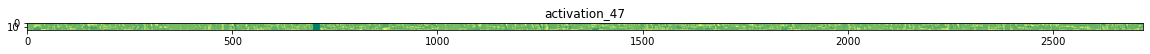

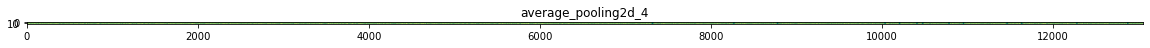

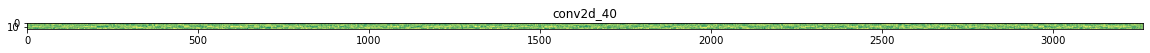

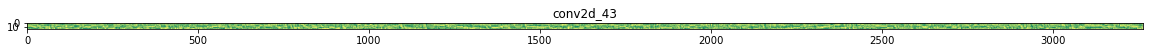

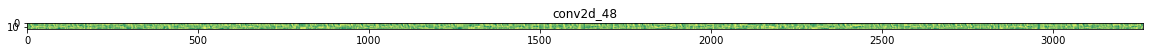

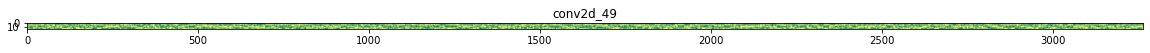

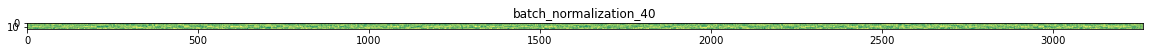

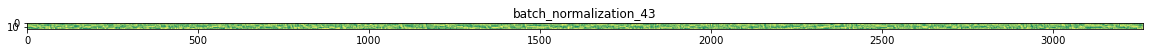

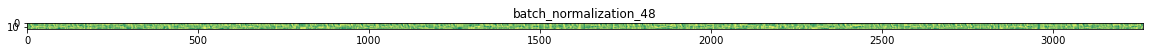

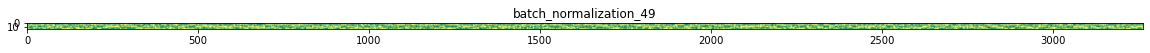

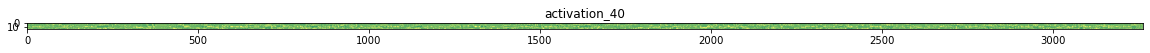

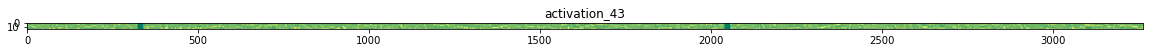

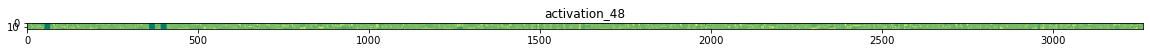

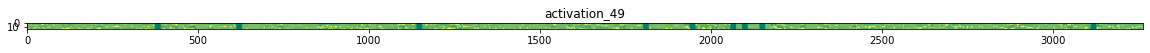

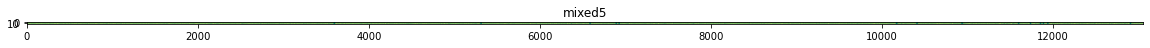

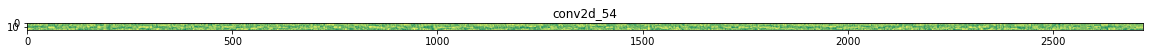

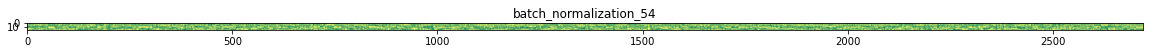

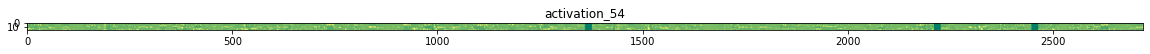

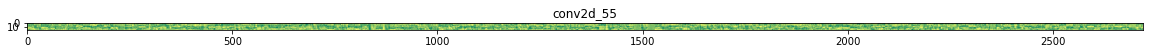

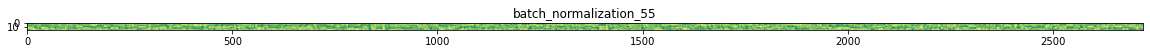

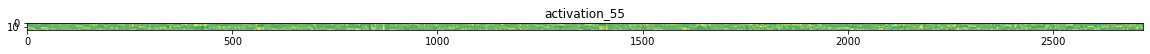

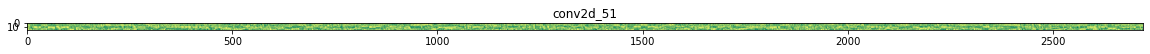

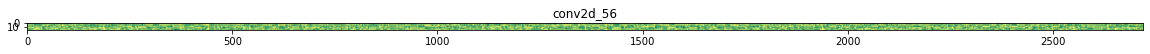

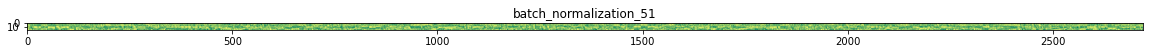

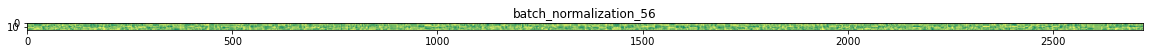

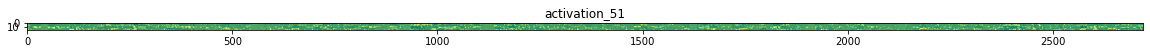

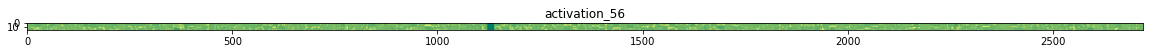

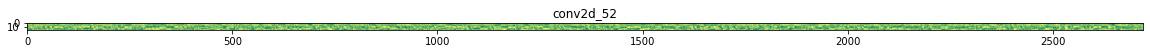

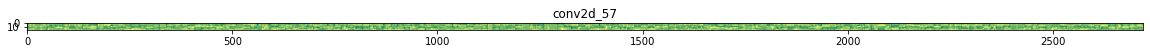

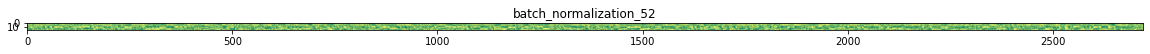

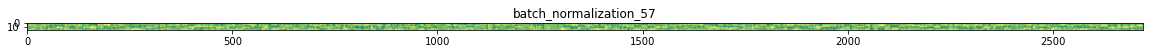

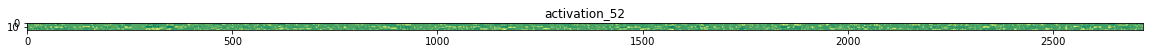

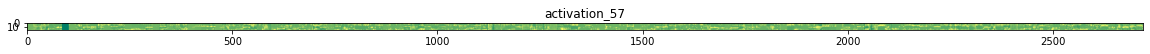

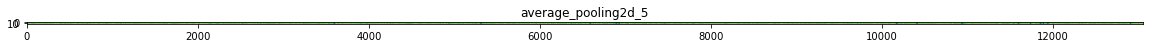

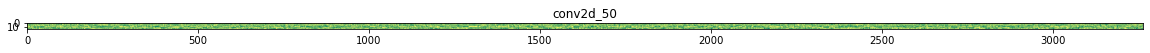

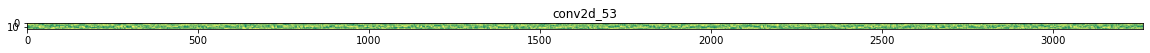

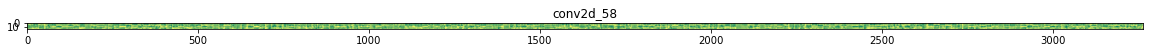

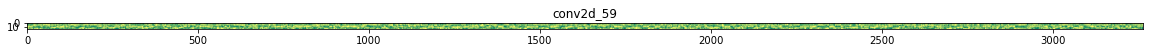

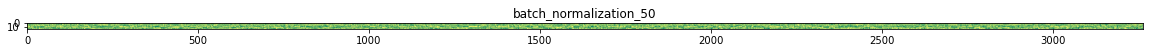

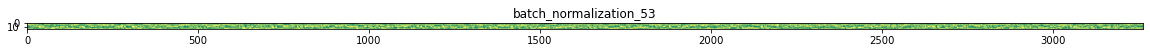

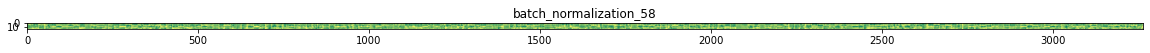

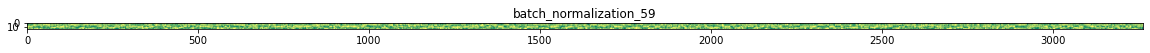

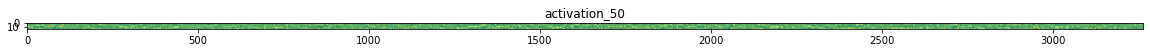

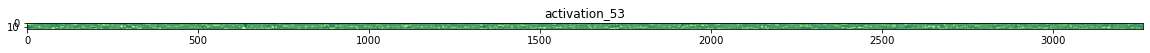

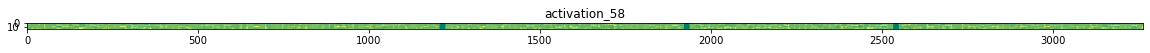

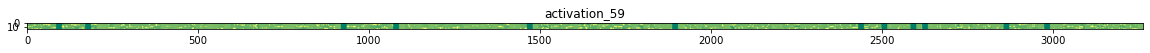

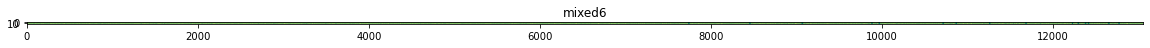

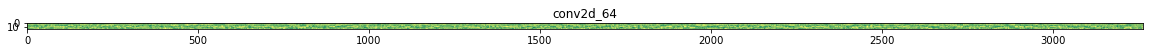

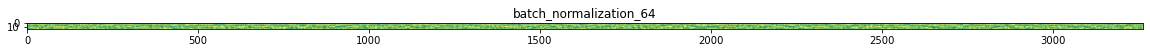

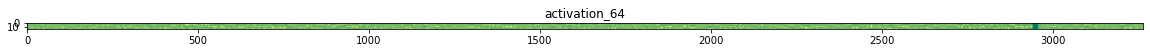

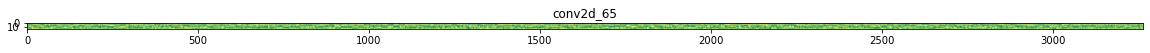

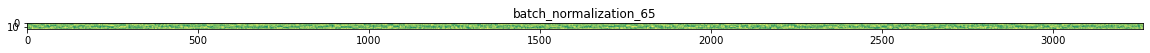

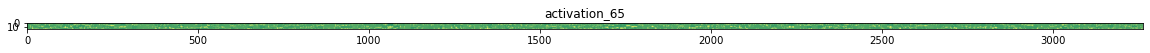

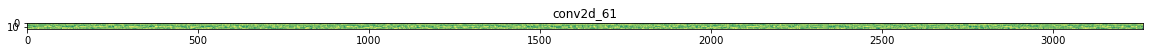

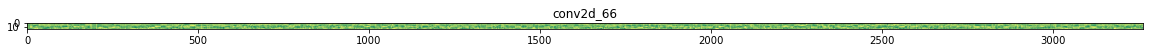

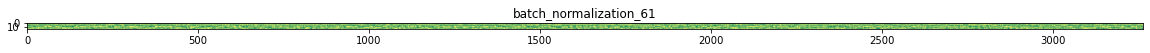

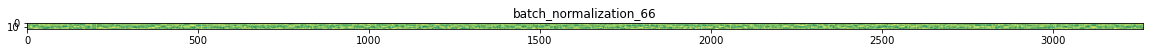

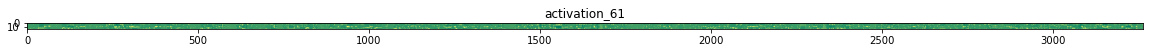

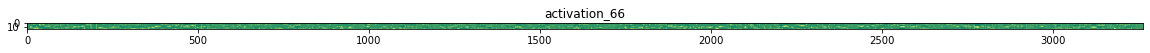

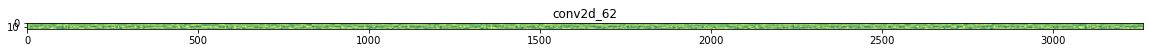

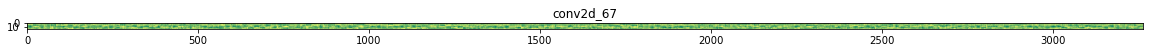

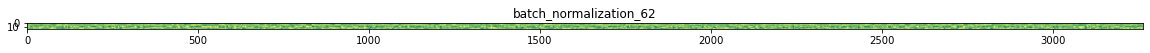

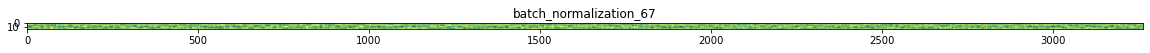

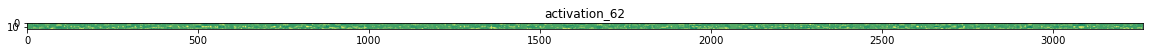

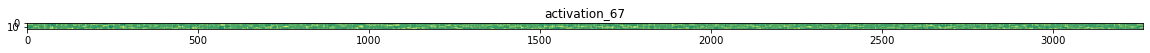

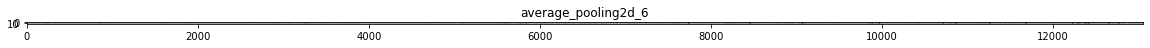

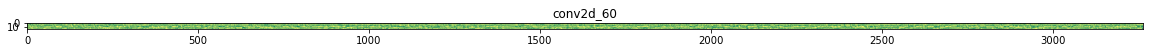

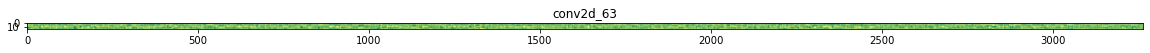

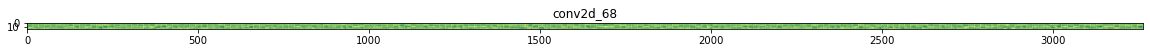

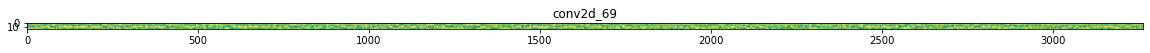

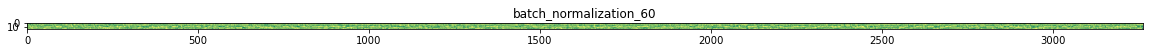

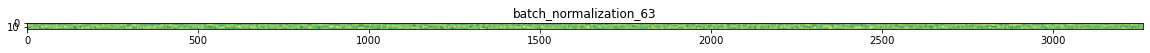

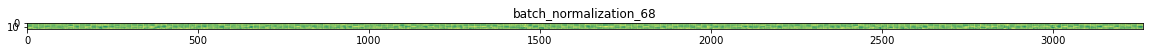

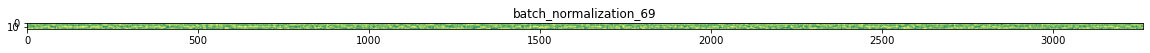

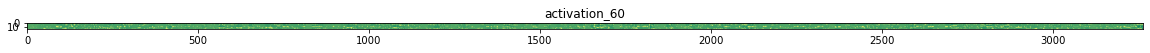

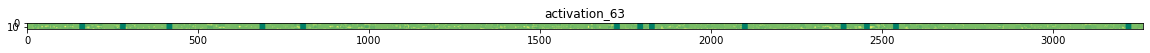

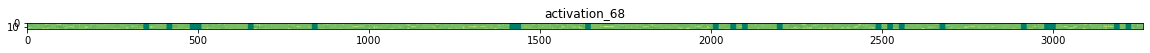

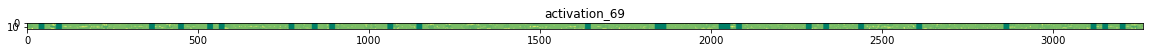

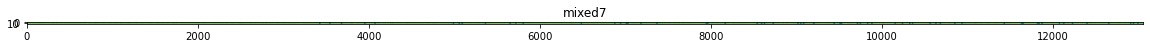

In [16]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
defective_img_files = [os.path.join(train_defective_dir, f) for f in train_defective_fnames]
nondefective_img_files = [os.path.join(train_nondefective_dir, f) for f in train_nondefective_fnames]
img_path = random.choice(defective_img_files + nondefective_img_files)

img = load_img(img_path, target_size=(300,300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
    # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
      # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='summer')